# Customer churn in telecommunication
Churn means a customer used to spend a company but no longer do so. Analyzing customer churn is vital as it directly impacts revenue and a company's long-term sustainability. Understanding the reasons behind churn and implementing effective retention strategies is crucial in this competitive landscape, ensuring telecom companies can thrive and maintain their customer base.



## Table of contents:
* [A. Data dictionary](#a-data-dictionary)

## A. Data dictionary<a class="anchor" id="a-data-dictionary"></a>
This dataset shows which patrons have churned in a telecommunication company and their information.
- Target: Churn (customers who left within last month)
- Independent variables / features:
     1. Demographics: gender, senior citizen, partner, dependents   
     2. Services that customers have signed up for: phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
     3. Customer account information: tenure, contract, payment method, paperless billing, monthly charges, total charges
- Data source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

## B. Setup
I used VS Code to take advantage of its workplace function, so I can use relative path instead of absolute path in my analysis, which makes this data science more portable. You can follow the documentation from VS code to set up the environment [here ](https://code.visualstudio.com/docs/datascience/data-science-tutorial).

After setting up the environment, you can install more libraries to your environment doing the following:
1. Go to Miniconda prompt
2. Type 'conda activate <name_of_your_environment>' (Package will be installed in a contained environment so that it won't mess up with other projects)
3. Type 'conda install <package_name>'


### Libraries

In [106]:
# libraries
# organization
import os

# data manupilation & visaulziation for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

# handle imbalanced classifcation
# PS: need sklearn version 1.2.2 to avoid error, 1.3.0 got error; install with command 'conda install imbalanced-learn'
import imblearn            
from collections import Counter
from imblearn.over_sampling import SMOTE  # oversampling
from imblearn.pipeline import Pipeline

# modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from xgboost import XGBClassifier

import tensorflow as tf     # need 2.4.0 or below for feature importance
from tensorflow import keras
from tensorflow.keras import layers

# explain model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from sklearn.inspection import PartialDependenceDisplay

# folder
folder_input = '02_input'

### Package version
These are the package version I used, for reproduciable project.

In [107]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.0.3
numpy==1.24.3
seaborn==0.12.2
imblearn==0.10.1
tensorflow==2.10.0
tensorflow.keras==2.10.0
eli5==0.13.0
shap==0.42.1


## C. Basic dataset information

Let's understand the dataset a bit more.


Import data:

In [108]:
org = pd.read_csv(os.path.join('..', folder_input, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))
org.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Dimension:

In [109]:
org.shape


(7043, 21)

Data types:

In [110]:
org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Check missing data:

In [111]:
# any missing values
org.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Unique value of categorical data:

In [112]:
colnames = org.select_dtypes(include=['object']).columns

for i in colnames:
    print(i, ": ", org[i].unique())

customerID :  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender :  ['Female' 'Male']
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges :  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn :  ['No' 'Yes']


### Data cleansing

Total Charges should be numerical data. But I got an error when attempting to change it from object to numeric, because a few of its value is ' ' instead of 0 when customers have 0 tenure. CustomerID also doesn't seem to have much information, so let's delete it too.

In [113]:
# customer id
org = org.drop('customerID', axis=1)    # 1 = column, 0 = row

# total charges: change from " " to 0
org['TotalCharges'] = org['TotalCharges'].str.replace(" ", "0", case=False, regex=False)
org = org.astype({'TotalCharges': 'float64'})

You could use [data wrangler extension](https://devblogs.microsoft.com/python/data-wrangler-release/) from VS Code to do basic data exploration, which could save a lot of time. For demonstration purpose, I continue to explore the data through the traditional coding way first.

## D. Exploratory data analysis (EDA) & Feature Engineering

### 1. Target variable: Churn

Let's explore the target variable first. 

In [114]:
# churn count
cnt = org.Churn.value_counts()
print('Count of Churn \n', cnt, '\n')

# churn %
cnt_perent = cnt/org.shape[0] * 100
print('Percentage of Churn \n', cnt_perent, '\n')

# Churned customers' value
print('Monthly Charges from Customers by Churn Group')
org.groupby('Churn')['MonthlyCharges'].sum() / org['MonthlyCharges'].sum() * 100


Count of Churn 
 Churn
No     5174
Yes    1869
Name: count, dtype: int64 

Percentage of Churn 
 Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64 

Monthly Charges from Customers by Churn Group


Churn
No     69.496648
Yes    30.503352
Name: MonthlyCharges, dtype: float64

26.5% of customers churned last month, and they contributed to 30.5% of monthly revenue. These are valuable customers. It also indicates that the dataset is imbalanced and we have to address this for a more accurate model later.

### 2. Independent variables (numerical)
There are only a few numerical independent variables in this dataset: tenure, Monthly Charges, and Total Charges. Let's observe their distrubiton by churn status.

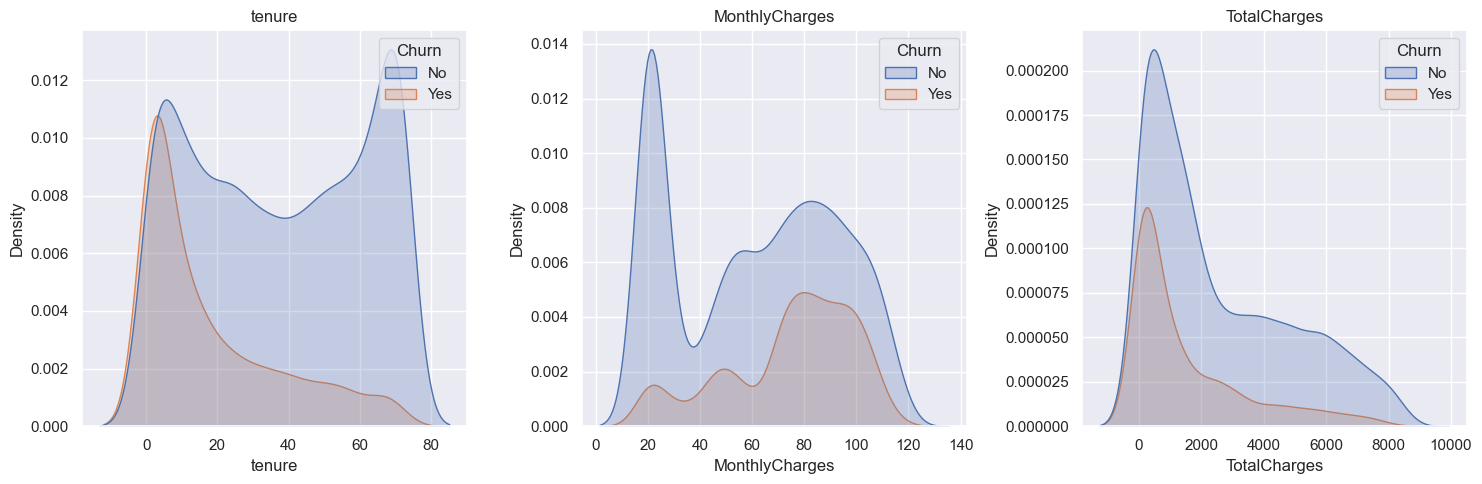

In [115]:
# numerical
def plot_numerical(variables, nrow, ncol, size):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i, variable in enumerate(variables):
        ax = axes[i]
        sns.kdeplot(data=org, x=variable, hue='Churn', fill=True, ax=ax)
        ax.set_title(variable)

    plt.tight_layout()
    plt.show()


# plot
var_num = ['tenure', 'MonthlyCharges', 'TotalCharges']
plot_numerical(var_num, 1, 3 ,5)


Let's also observe how these 3 numerical variables relate to each other.

The figure layout has changed to tight


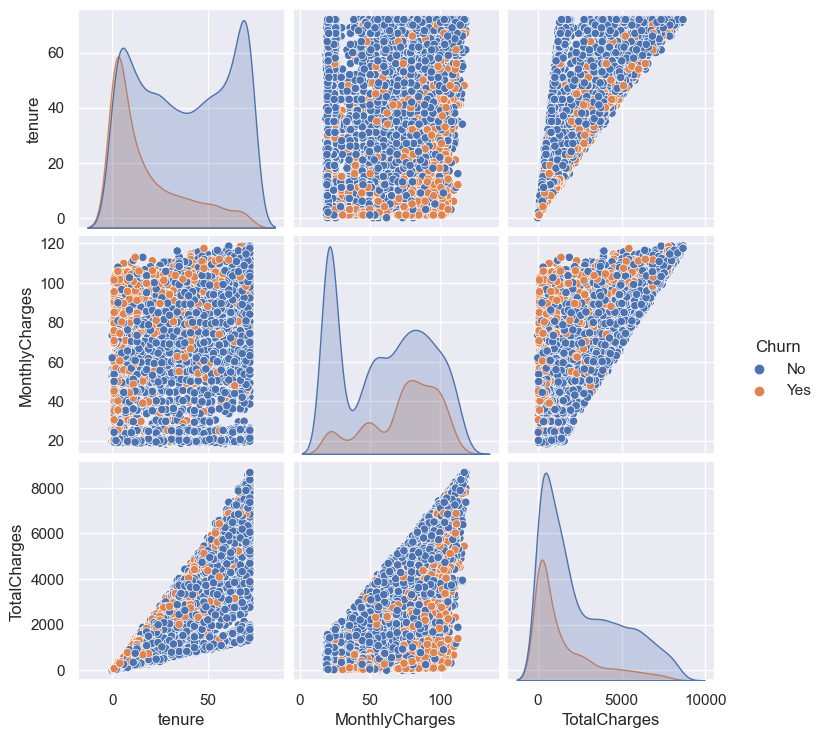

In [116]:
sns.pairplot(org[var_num + ['Churn']], hue='Churn')

Observations:

Customers who churned have these characters:
- Have been with the company in a shorter time.
- Have a higher monthly charge and they may be quite price-sensitive.
- Do not necessarily have a high total charge as they may not stay in the company for long.
- From the pair plot, Total Charges seems to have a high correlation with Tenure and Monthly Charges. 

### 3. Feature engineering
Feature engineering means the extraction of addtional information from raw data to improve the performance of machine learning model. From the pair plot above, we observed that Total Charges are closely related to Tenure and Monthly Charges.

To capture this relationship, we can create a new variable called **"Tenure_Calculated_Diff."** This variable represents the number of months a customer would have stayed with us based on their Total Charges divided by Monthly Charges. For instance, if a customer has a Tenure_Calculated_Diff of 2 and a tenure of 6 months, it means they would have used that monthly charge to stay with us for 8 months, but they actually stayed for only 6 months due to a change in the monthly charge (i.e., it became more expensive).

Distribution of the difference between the tenure column and the calculated tenure
count    7043.000000
mean        0.002282
std         1.135584
min        -6.941748
25%        -0.517380
50%         0.000000
75%         0.488900
max         7.706941
Name: Tenure_Calculated_Diff, dtype: float64


Text(0.5, 1.0, 'Distribution of difference between the tenure column and the calculated tenure')

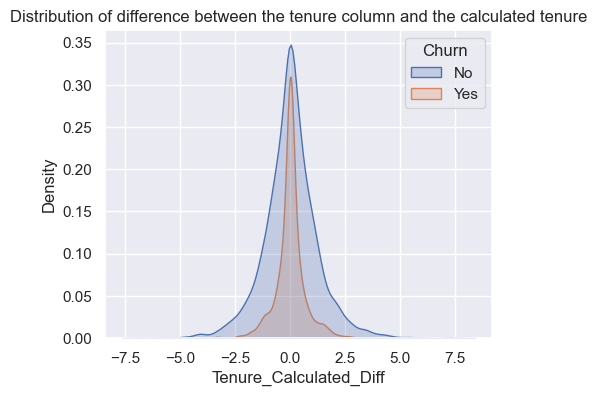

In [117]:
# check if their monthly charge ever changed
org['Tenure_Calculated_Diff'] = org['TotalCharges']/org['MonthlyCharges'] - org['tenure']

# confirm it's different
print('Distribution of the difference between the tenure column and the calculated tenure')
print(org['Tenure_Calculated_Diff'].describe())

# visulization
sns.kdeplot(data=org, x='Tenure_Calculated_Diff', hue='Churn', fill=True)
plt.title('Distribution of difference between the tenure column and the calculated tenure')


What is the use of the variable Tenure_Calculated_Diff? It helps us to understand if customers have ever change the monthly charge since they used the teleom services:
- Tenure_Calculated_Diff = 0: Same monthly charges since using telcom service
- Tenure_Calculated_Diff > 0: Current monthly charge is more than before (more expensive)
- Tenure_Calculated_Diff < 0: Current monthly charge is less than before (less expensive)


From the distribution above, customers are inclined to churn when they haven't altered their monthly charge. To capture the pattern, I created another variable **Is_MonthlyCharges_Changed**. This variable assumes customers haven't adjusted their monthly charge when Tenure_Calculated_Diff is between 0.5 and -0.5 (i.e. less than the difference of 1 month in tenure calculation).

In [118]:
# indicate contract change
org['Is_MonthlyCharges_Changed'] = ((org['Tenure_Calculated_Diff'] < -0.5) | (org['Tenure_Calculated_Diff'] > 0.5)).astype('int')

### 4. Independent variables (Categorical)

We're dealing with several categorical variables here. To analyze their impact on churn rate, we'll group them by their unique values and examine the percentage of churn within each value group. If a variable significantly influences churn, we should notice a clear difference in churn rates among the unique values within that variable.

In [119]:
# function to plot categorical data

# categorical
def plot_category(variables, nrow, ncol, size, rotation):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()        # cannot go to the second row of fig without this
    
    for i, variable in enumerate(variables):
        org_sort = org.sort_values(variable)              # for sorting value in the field first (align with label encoder position later, easier to read)
        ax = sns.countplot(data=org_sort, x=variable, hue='Churn', ax=axes[i])
        # plt.xticks(rotation=rotation)
        
        # Calculate percentages and annotate
        total = len(org_sort)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.15
            y = p.get_height() + 10
            ax.annotate(percentage, (x, y), fontsize=10)
        
        ax.set_title(variable)
        ax.tick_params(axis='x', rotation=rotation)

    plt.tight_layout()
    plt.show()


#### Demographics

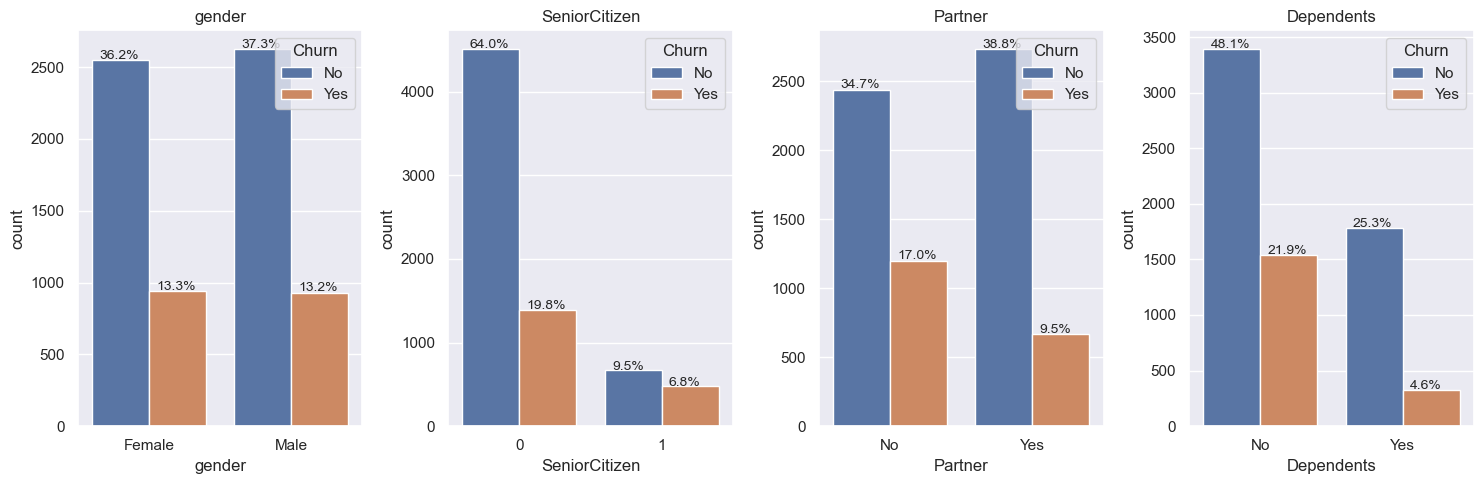

In [120]:
var_demo = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plot_category(var_demo, 1, 4, 5, 0)


Observations:
- gender: Not obvious impact
- Senior citizen: Senior citizens are more likely to churn.
- Partner: Customers without partner are more likely to churn.
- Dependents: Customers without dependents are more likely to churn.

#### Subscribed services

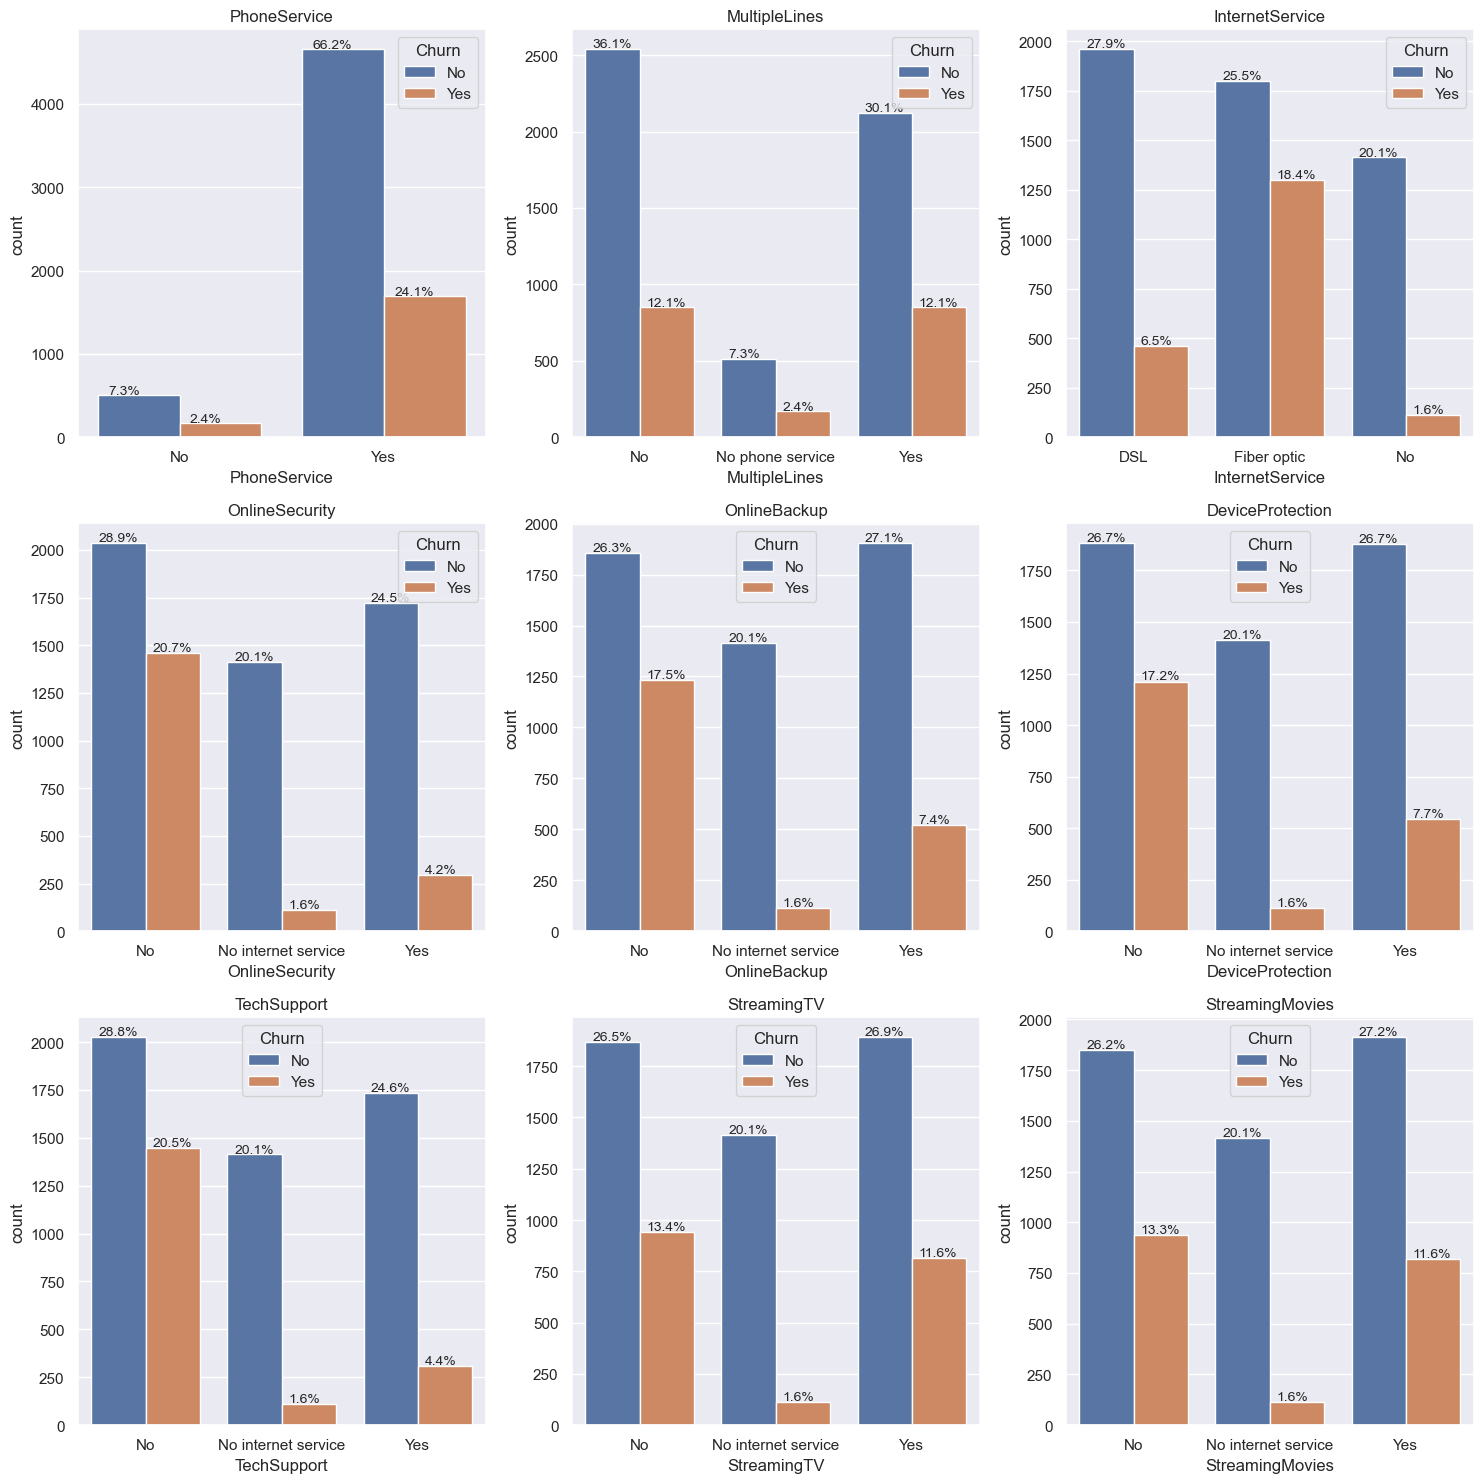

In [121]:
var_service = [
    'PhoneService', 
    'MultipleLines', 
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies'
    ]

plot_category(var_service, 3, 3, 15, 0)

Observations:
- Phone services and multiple lines: No obvious impact
- Internet Services: Fiber optic customers are likely to churn.
- Addtional internet services (online security, online backup, device protection, tech support): Internet customers not using addtional internet services  are likely to churn.
- Entertainment (streaming TV and movies): No obvious impact

#### Customer account information

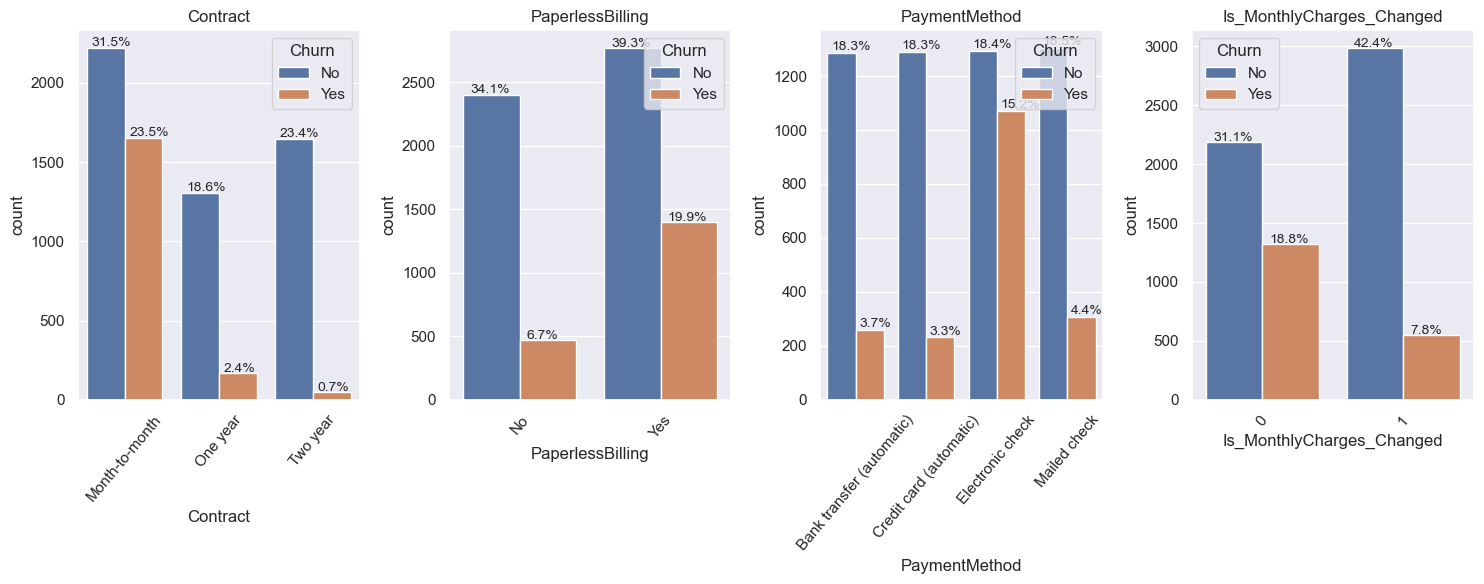

In [122]:
var_account_cat = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Is_MonthlyCharges_Changed']
plot_category(var_account_cat, 1, 4, 6, 50)

Observations:
- Contract: Customers without locked contract (month-to-month) are likely to churn.
- Paperless Billing: No obvious impact
- Payment method: Customers paid with electronic check are likely to churn.
- Is Monthly Charges Changed: Customers who didn't change its contract are likely to churn.

### 5. Monthly Charges vs services
How much are charged to these services?

In [123]:
def plot_charges(variables, nrow, ncol, size, rotation):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i, variable in enumerate(variables):
        org_sort = org.sort_values(variable)              # for sorting value in the field first
        ax = sns.boxenplot(data=org_sort, x=variable, y='MonthlyCharges', hue='Churn', ax=axes[i])        
        # ax.set_title(variable)
        ax.tick_params(axis='x', rotation=rotation)

    plt.tight_layout()
    plt.show()


##### Monthly charges vs subscribed services:

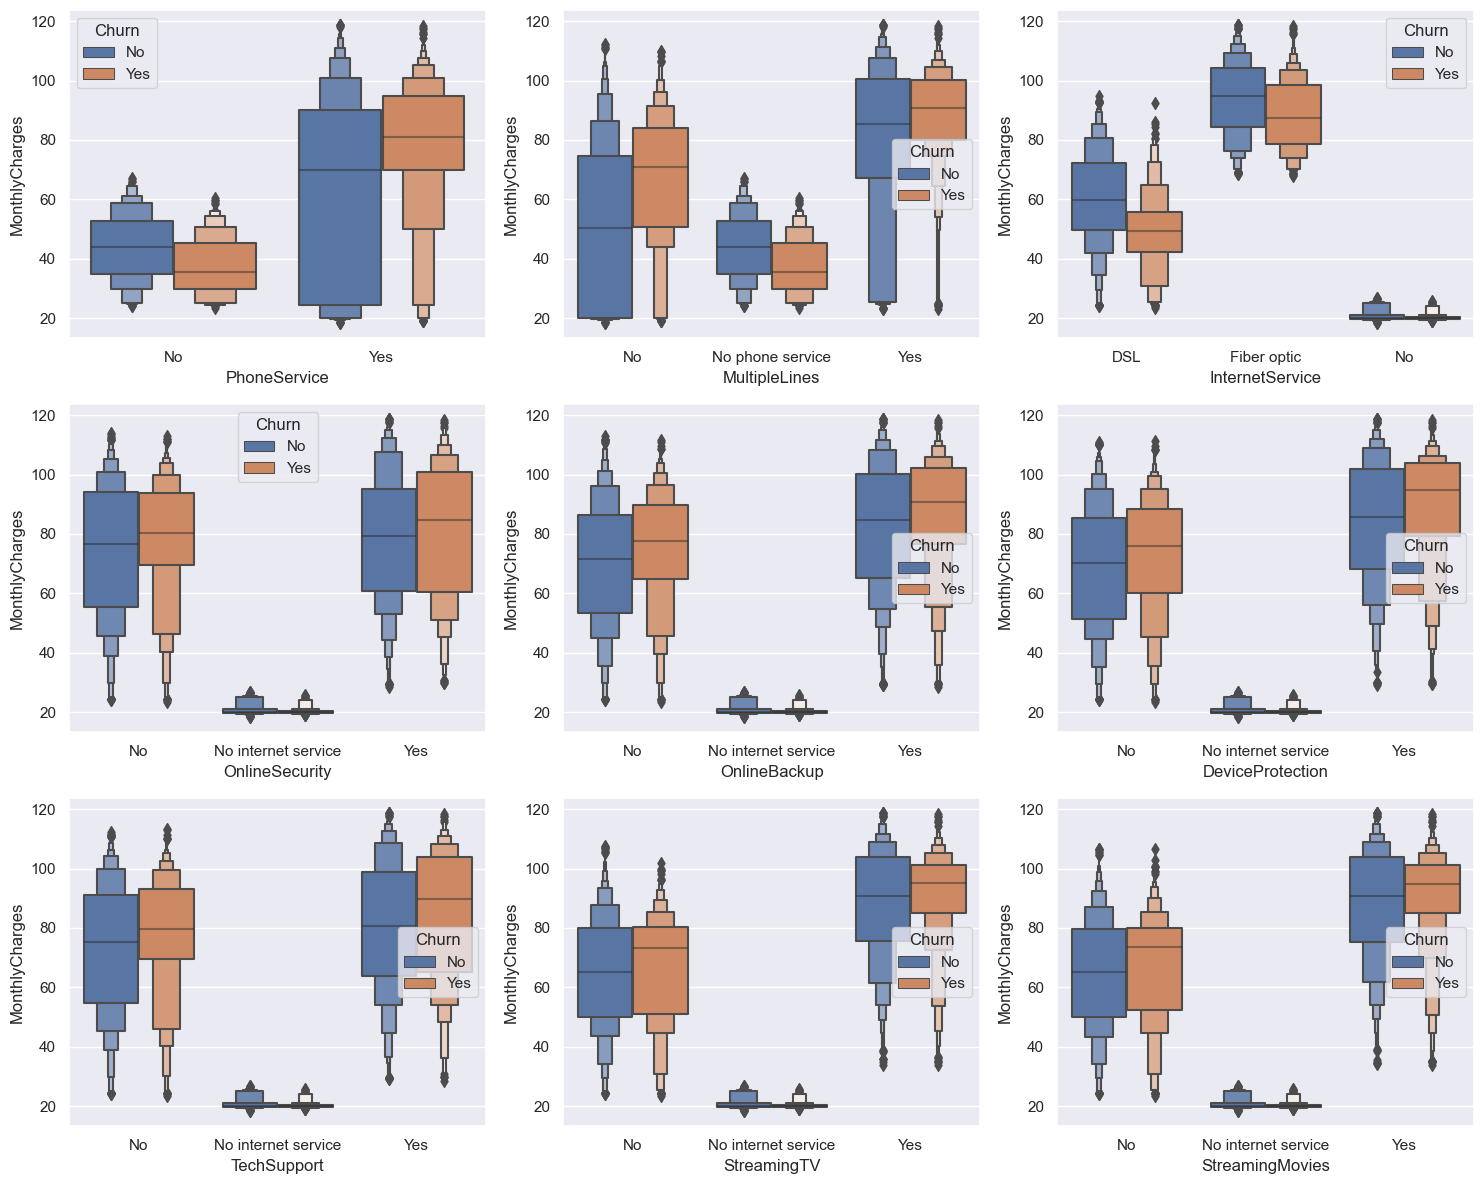

In [124]:
plot_charges(var_service, 3, 3, 12, 0)

Observations:
- Internet services are more expensive than phone services.
- Within internet services, Fiber optic is more expensive than DSL.
- For internet users, customers subscribed to addtional internet services are charged more, indicating these addtional services are not free.

##### Monthly charges vs account information

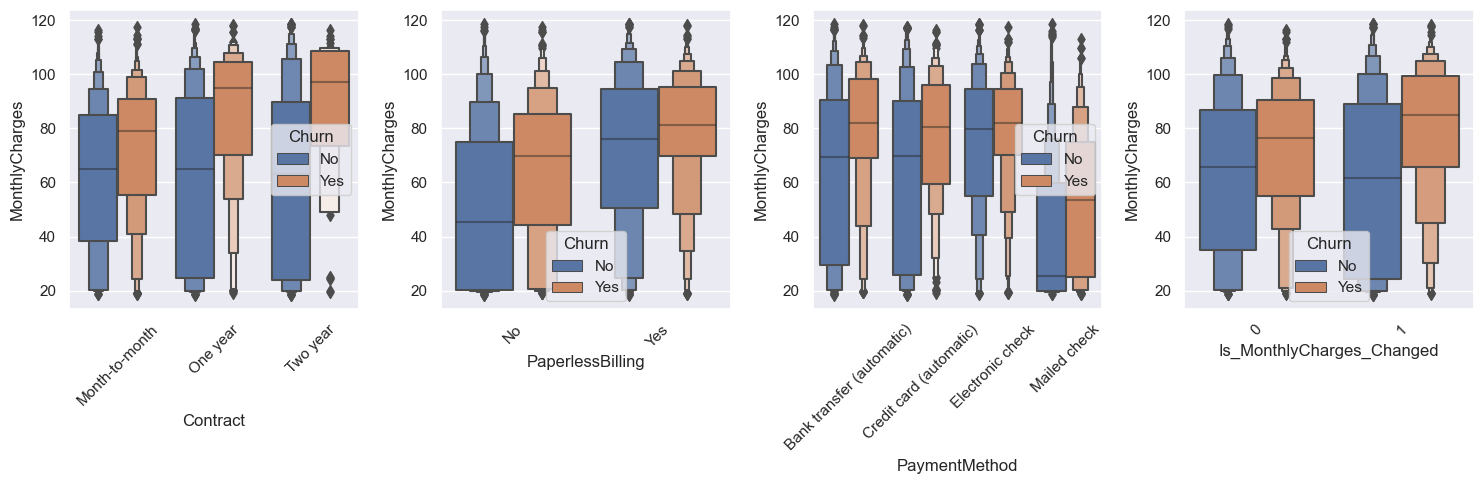

In [125]:
plot_charges(var_account_cat, 1, 4, 5, 45)

We haven't noticed any significant patterns between monthly charges and the account information variables. The correlation between them might be subtle. To explore this further, we'll need to use machine learning techniques for a more in-depth analysis.

## E. Turn imbalanced data to balanced data

In the EDA section, we've observed that the target variable "Churn" is predominantly biased toward the "No" category. This imbalance can cause our model to be biased and not perform accurately. To address this issue, we'll employ a technique called oversampling, which means we'll create more data for the minority group (Churn = 'Yes'). However, before doing that, we need to convert our categorical data into numerical format.

### 1. Label encoding

Values of categorical variables before and after label encoding:

In [21]:
# encode categorical data
# Need numeric data for resampling
# PS: Use label encoder when there is no order within the categorical data
category_encoder = LabelEncoder()

var_cat = var_demo + var_service + var_account_cat + ['Churn']
for i in var_cat:
    org[i] = category_encoder.fit_transform(org[i])
    print(i,' : ',org[i].unique(),' = ', category_encoder.inverse_transform(org[i].unique()))

gender  :  [0 1]  =  ['Female' 'Male']
SeniorCitizen  :  [0 1]  =  [0 1]
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Is_MonthlyCharges_Changed  :  [0 1]  =  [0 1]
Churn  :  [0 1]  =  ['N

### 2. Oversampling

We decided to use the oversampling strategy because our dataset is quite small. After applying oversampling, we've increased the number of minority cases (Churn = 'Yes') so that it's now equal in size to the majority class (Churn = 'No').

In [22]:
# resampling
# PS: sampling_strategy = 1 means over sample the minority to 100% of majority

over_sampler = SMOTE(sampling_strategy=1, random_state=0)

# seperate X and y from original dataset
X = org.copy()
y = X.pop('Churn')

X, y = over_sampler.fit_resample(X, y)
Counter(y)


Counter({0: 5174, 1: 5174})

## F. Mutual information
According to Kaggle, Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

In [23]:
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

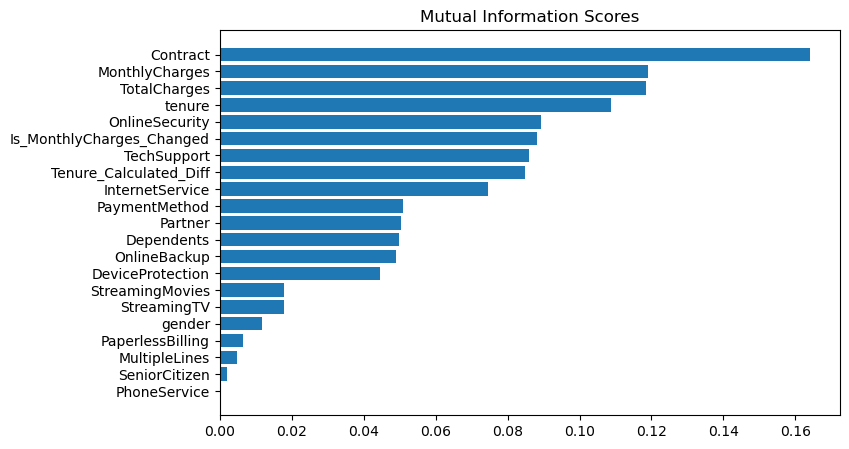

In [24]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## G. Model preparation

### 1. Create training and testing datasets

In [25]:
# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### 2. Preprocessing

Review the data once more. The categorical variables have been encoded using label encoder in the previous section. To enhance the model's performance, we should also standardize the numerical variables, ensuring the model trains effectively regardless of the units used.

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     10348 non-null  int32  
 1   SeniorCitizen              10348 non-null  int64  
 2   Partner                    10348 non-null  int32  
 3   Dependents                 10348 non-null  int32  
 4   tenure                     10348 non-null  int64  
 5   PhoneService               10348 non-null  int32  
 6   MultipleLines              10348 non-null  int32  
 7   InternetService            10348 non-null  int32  
 8   OnlineSecurity             10348 non-null  int32  
 9   OnlineBackup               10348 non-null  int32  
 10  DeviceProtection           10348 non-null  int32  
 11  TechSupport                10348 non-null  int32  
 12  StreamingTV                10348 non-null  int32  
 13  StreamingMovies            10348 non-null  int

In [27]:
# test keep numerical data
# encoder
num_encoder = MinMaxScaler()
num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[var_num]))
num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[var_num]))

#encoding removed index; put it back
num_cols_train.index = X_train.index
num_cols_test.index = X_test.index

# Add column name
num_cols_train.columns = num_encoder.get_feature_names_out() + '_Scaled'
num_cols_test.columns = num_encoder.get_feature_names_out() + '_Scaled'

# Add new cols to dataset
X_train = pd.concat([X_train, num_cols_train], axis=1)
X_test = pd.concat([X_test, num_cols_test], axis=1)

X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Tenure_Calculated_Diff,Is_MonthlyCharges_Changed,tenure_Scaled,MonthlyCharges_Scaled,TotalCharges_Scaled
4053,1,1,0,0,11,1,2,0,2,2,...,0,0,0,60.25,662.95,0.003320,0,0.152778,0.417910,0.076335
6829,1,0,1,1,8,1,0,2,1,1,...,2,0,1,19.60,125.00,-1.622449,1,0.111111,0.013433,0.014393
1141,1,0,0,1,6,1,0,2,1,1,...,0,1,3,20.20,98.35,-1.131188,1,0.083333,0.019403,0.011324
845,0,0,1,1,15,1,0,2,1,1,...,1,0,3,20.55,295.95,-0.598540,1,0.208333,0.022886,0.034077
3497,0,1,1,0,2,1,0,1,0,0,...,0,1,2,69.30,153.80,0.219336,0,0.027778,0.507960,0.017709


I decided to keep the original numerical data in the dataset, as they are useful in some models.

In [28]:
# # numerical data

# # encoder
# num_encoder = MinMaxScaler()
# num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[var_num]))
# num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[var_num]))

# #encoding removed index; put it back
# num_cols_train.index = X_train.index
# num_cols_test.index = X_test.index

# # add back colnames
# num_cols_train.columns = num_encoder.get_feature_names_out()
# num_cols_test.columns = num_encoder.get_feature_names_out()

# # Remove numerical  columns (will replace with encoding)
# cat_X_train = X_train.drop(var_num, axis=1)
# cat_X_test = X_test.drop(var_num, axis=1)

# # Add one-hot encoded columns to numerical features
# X_train = pd.concat([cat_X_train, num_cols_train], axis=1)
# X_test = pd.concat([cat_X_test, num_cols_test], axis=1)


# X_train.head()

### 3. Model evaluation

I'll use three different methods to perform binary classification: random forest, XGBoost, and TensorFlow. This way, we can determine which model provides the most accurate predictions. We'll assess the predictions using metrics like accuracy score, confusion matrix, and classification report. I'll explain how to interpret these results in detail later.

The function below summarizes how we evaluate a model.

In [32]:

# model evaluation (output)
def model_evaluation(classification_model, X_test, y_test):
    # prediction
    preds = classification_model.predict(X_test)
    preds = (preds >= 0.5).astype('int')            # handle tensorflow's output
    
    # accuracy score
    print('Accuracy score: \n', accuracy_score(y_test, preds), '\n')
    
     # classification report
    print('Classification matrix: \n', classification_report(y_test, preds))
    
    # confusion matrix
    cf_matrix = confusion_matrix(y_test, preds)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percent = ['{0:.0%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percent)]
    labels = np.asarray(labels).reshape(2, 2)
    
    sns.set(rc={'figure.figsize':(5,4)})
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')



                

## H. Random forest

We start by getting the data ready for modeling and check the accuracy of our model. I also assess permutation importance to identify unimportant variables for the prediction. Then, I gradually eliminate these irrelevant variables one by one to check if it enhances the model's performance.

In [37]:
# feature de-selection
# Add one by one after seeing the result from permutation importance
feature_not_selected = [
    'StreamingMovies',
    'MultipleLines',
    'SeniorCitizen',
    'StreamingTV',
    'gender'
    ] + var_num


# remove columns
X_train_rf = X_train.drop(feature_not_selected, axis=1)    # axis=1 for columns
X_test_rf = X_test.drop(feature_not_selected, axis=1)


I wrote a loop to find the optimal estimator for the random forest model, by looking at when the accuracy score reached its highest point.

In [46]:
# test the best number of tree
def get_accuracy(no_of_estimators):
    rf = RandomForestClassifier(n_estimators=no_of_estimators, random_state=0)
    rf_model = rf.fit(X_train_rf, y_train)
    preds = rf_model.predict(X_test_rf)
    acc = accuracy_score(y_test, preds)
    return(acc)
    

# loop to check best no of estimators
for estimators in [25, 50, 100, 500, 750, 1000]:
    my_acc = get_accuracy(estimators)
    print('No of estimators ', estimators, "; accuracy score ", my_acc)


No of estimators  25 ; accuracy score  0.8419018167761886
No of estimators  50 ; accuracy score  0.843448009277155
No of estimators  100 ; accuracy score  0.8426749130266719
No of estimators  500 ; accuracy score  0.8484731349052957
No of estimators  750 ; accuracy score  0.8484731349052957
No of estimators  1000 ; accuracy score  0.8465403942790878


The accuracy score peaked when the estimators = 500. Let's use it in the random forest model.

Accuracy score: 
 0.8484731349052957 

Classification matrix: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1290
           1       0.83      0.87      0.85      1297

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587



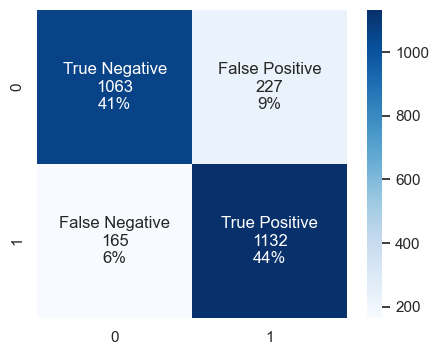

In [45]:
# model
rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf_model = rf.fit(X_train_rf, y_train)

model_evaluation(rf_model, X_test_rf, y_test)

**Practical applications of evaluation:**

The random forest model shows 84.8% accuracy, but this alone isn't sufficient. Companies allocate marketing funds to retain potentially churned customers, so what matters more are the precision and recall among churned customers.

- Precision for churned customers: This measures how accurately we identify customers who will churn. It's the ratio of true positives to all customers predicted to churn.
- Recall for churned customers: This gauges our ability to catch all customers who genuinely churn. It's the ratio of true positives to all customers who actually churn.

Precision helps us assess whether we're spending marketing dollars on customers who won't actually churn. For instance, the precision in the churn group here (label = 1 in the confusion matrix) is 83%, it means that 17% of the customers we target won't churn, resulting in wasted marketing spending. Meanwhile, a recall of 87% means that 13% of customers who might churn haven't been targeted, leading to a missed opportunity.

In [31]:
# permutation importance
no_of_features = X_train_rf.shape[1]

perm = PermutationImportance(rf_model, random_state=1).fit(X_test_rf, y_test)
eli5.show_weights(perm, top=no_of_features, feature_names = X_test_rf.columns.tolist())   #default 20 variables, force it to show all variables by using top

Weight,Feature
0.1089 ± 0.0161,Contract
0.0478 ± 0.0124,MonthlyCharges_Scaled
0.0435 ± 0.0051,TechSupport
0.0405 ± 0.0025,OnlineSecurity
0.0207 ± 0.0032,OnlineBackup
0.0196 ± 0.0061,tenure_Scaled
0.0169 ± 0.0022,TotalCharges_Scaled
0.0167 ± 0.0084,Is_MonthlyCharges_Changed
0.0152 ± 0.0032,PaymentMethod
0.0118 ± 0.0033,Tenure_Calculated_Diff


Based on the permutation importance analysis, the type of contract (month-to-month, one-year, two-year) is the most critical factor in predicting customer churn. The second most influential factor is the monthly charges.

We can obtain feature importance directly from the model. However, since the "eli5" package already accomplishes this with additional information, I've disabled the code below but kept it for reference.

In [ ]:
# # feature importance
# rf_importance = pd.Series(rf_model.feature_importances_, index=X_train_rf.columns).sort_values(ascending= False)
# rf_importance

# # plot it
# sns.set(rc={'figure.figsize':(11,5)})
# sns.barplot(x = rf_importance.values,
#             y = rf_importance.index)

## I. XGBoost

Next, I used XGBoost to train our data. The process is similar to random forest: I initially train the model and then refine it by removing some variables based on their permutation importance. I also assess the model's performance at each testing round to find the best possible performance.

In [48]:
# feature selection
feature_not_selected = [
    'StreamingMovies',
    'MultipleLines',
    'SeniorCitizen',
    'StreamingTV',
    'gender',
    
    'MonthlyCharges_Scaled',
    'tenure_Scaled',
    'TotalCharges_Scaled'
    ]

# remove columns
X_train_xgb = X_train.drop(feature_not_selected, axis=1)    # axis=1 for columns
X_test_xgb = X_test.drop(feature_not_selected, axis=1)


Again, test the best number of estimators in the XGBoost model by looking at when the accuracy score peaks.

In [49]:
# test the best number of tree
def get_accuracy(no_of_estimators):
    xgb = XGBClassifier(n_estimators=no_of_estimators, random_state=0)
    xgb_model = xgb.fit(X_train_xgb, y_train)
    preds = xgb_model.predict(X_test_xgb)
    acc = accuracy_score(y_test, preds)
    return(acc)
    

# loop to check best no of estimators
for estimators in [25, 50, 100, 500, 750, 1000]:
    my_acc = get_accuracy(estimators)
    print('No of estimators ', estimators, "; accuracy score ", my_acc)

No of estimators  25 ; accuracy score  0.8372632392732895
No of estimators  50 ; accuracy score  0.8426749130266719
No of estimators  100 ; accuracy score  0.8477000386548125
No of estimators  500 ; accuracy score  0.8442211055276382
No of estimators  750 ; accuracy score  0.8426749130266719
No of estimators  1000 ; accuracy score  0.8407421724004639


The accuracy score peaked when the estimators = 100. Let's use it in the XGBoost model.

Accuracy score: 
 0.8477000386548125 

Classification matrix: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1290
           1       0.83      0.87      0.85      1297

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587



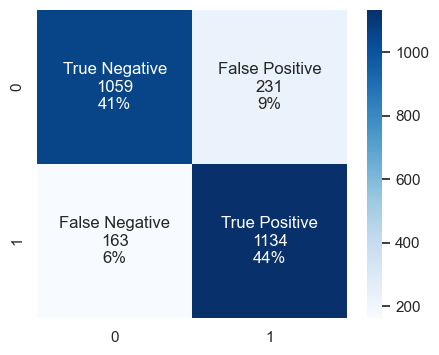

In [50]:
# xgboost
# Outstanding: To experiment with scale_pos_weight on imbalanced data
xgb_model = XGBClassifier(n_estimators = 100, random_state=0)
xgb_model.fit(
    X_train_xgb,
    y_train
)

model_evaluation(xgb_model, X_test_xgb, y_test)

Model evaluation:

The model accuracy stands at 84.7%, slightly below the random forest result. The precision and recall for churned customers is on par with the random forest.

In [51]:
# permutation importance
no_of_features = X_train_xgb.shape[1]

perm = PermutationImportance(xgb_model, random_state=1).fit(X_test_xgb, y_test)
eli5.show_weights(perm, top=no_of_features, feature_names = X_test_xgb.columns.tolist())

Weight,Feature
0.0839 ± 0.0078,Contract
0.0691 ± 0.0120,MonthlyCharges
0.0382 ± 0.0049,InternetService
0.0364 ± 0.0037,tenure
0.0332 ± 0.0133,TechSupport
0.0309 ± 0.0085,Is_MonthlyCharges_Changed
0.0305 ± 0.0082,OnlineSecurity
0.0256 ± 0.0104,TotalCharges
0.0229 ± 0.0078,OnlineBackup
0.0169 ± 0.0033,DeviceProtection


The XGBoost model also shows contract and monthly charges are the two most critical factors in predicting customer churn.

## J. Tensorflow

Then, I proceeded to train the data using TensorFlow. I created a learning curve to spot overfitting or underfitting and made adjustments to the model's layers and neurons for optimal results. I also implemented early stopping, ensuring the model stops when it no longer improves its performance.

In [56]:
# feature selection
feature_not_selected = [
    'StreamingMovies',
    'MultipleLines',
    'SeniorCitizen',
    'StreamingTV',
    'gender'
    ] + var_num


# remove columns
X_train_tf = X_train.drop(feature_not_selected, axis=1)    # axis=1 for columns
X_test_tf = X_test.drop(feature_not_selected, axis=1)

In [68]:
# define model
# ie structure of the neural network

tf.random.set_seed(0)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# model
tf_model = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape = [X_train_tf.shape[1]]),   # non-linear
    layers.BatchNormalization(),
    layers.Dense(6, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),      # classification
])

# model compile
# tell model what to adjust to  
tf_model.compile(
    loss = keras.losses.binary_crossentropy,                   # for classification
    optimizer = keras.optimizers.Adam(learning_rate=0.03),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),         # what else to show in each epoch
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

# fit model 
history = tf_model.fit(
    X_train_tf, 
    y_train,
    validation_data=[X_test_tf, y_test], 
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
    )

Best Validation Loss: 0.3713
Best Validation Accuracy: 0.8315


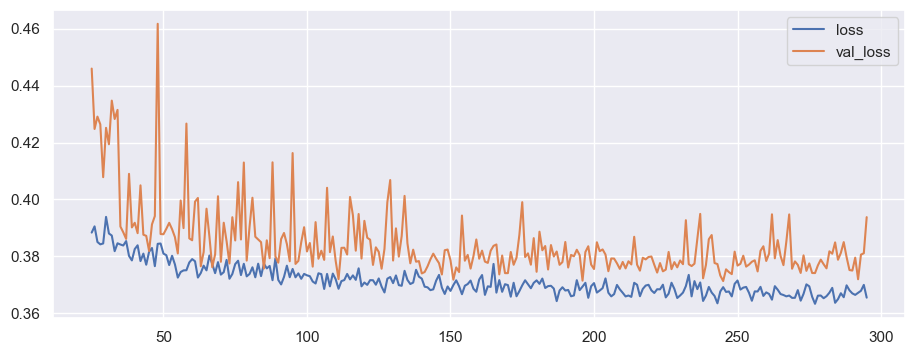

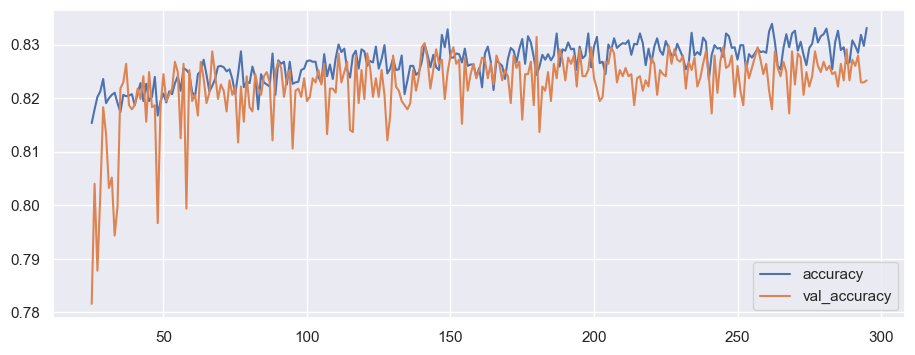

In [71]:
# observe overfitting/underfitting to adjust the model
sns.set(rc={'figure.figsize':(11,4)})

history_df = pd.DataFrame(history.history)
history_df.loc[25:, ['loss', 'val_loss']].plot()
history_df.loc[25:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

81/81 [==============================] - 0s 2ms/step
Accuracy score: 
 0.8264398917665249 

Classification matrix: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      1290
           1       0.82      0.83      0.83      1297

    accuracy                           0.83      2587
   macro avg       0.83      0.83      0.83      2587
weighted avg       0.83      0.83      0.83      2587



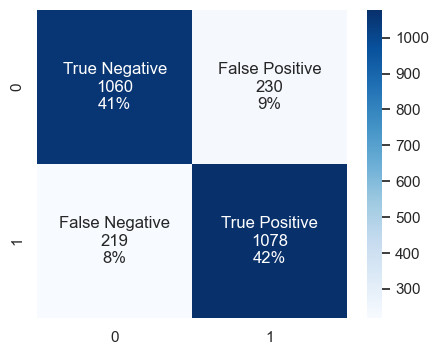

In [65]:
model_evaluation(tf_model, X_test_tf, y_test)

The TensorFlow model achieved an accuracy score of 82.6%. The precision and recall for churned customers are 82% and 83%, respectively. These results suggest that TensorFlow is not as effective for predicting outcomes in this dataset compared to random forest and XGBoost.

## K. Machine learning explainability

Besides achieving accurate predictions with a machine learning model, it's crucial to comprehend the role of each factor in the model. Two critical aspects in real-world scenarios are:
- Debugging: Does the model align with my domain expertise? Analyzing model insights helps verify if the model is constructed correctly.
- Applications: Understanding how different variables interact can provide insights into adjusting marketing strategies to prevent customer churn in the future. This is extremely important in the real business problem.

### 1. What are the tipping points?

Tipping point means the thershold where customers' churn rate changes significantly. We can create **partial dependence plots** for individual variables to understand how they affect customer churn. This helps us make informed changes to our offers and marketing strategies to retain more customers.

In [72]:
def plot_pdp_1D(variables, nrow, ncol, size):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i in range(len(variables)):         # Iterate over indices (because ax needs index too)
        PartialDependenceDisplay.from_estimator(rf_model, X_test_rf, [variables[i]], ax=axes[i])

    plt.tight_layout()
    plt.show()

In the graph, the y-axis represents how much the churn prediction changes when varible on the x-axis is change while other variables are kept constant.In this way, we can observe there is any tipping point where customers churn rate increases significantly. Addtionally, If the difference between the lowest and highest y-axis values is large, it means that the variable being studied has a bigger impact on churn prediction compared to other variables.

Let's plot the partial dependence plots the numerical variables first, and then calculate the tipping point where customer behavior changes.

#### Charges and tenure

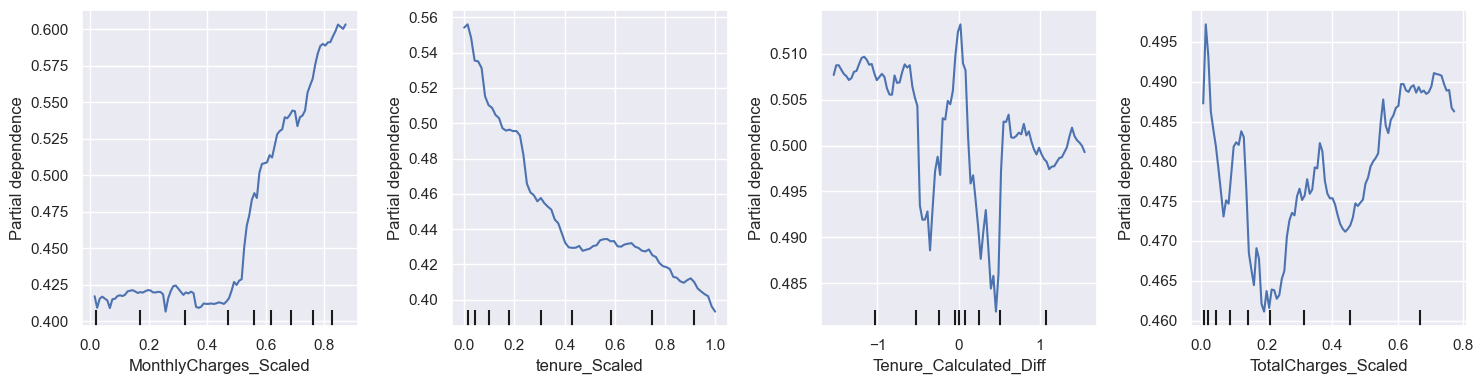

In [73]:
var_num_ml = ['MonthlyCharges_Scaled', 'tenure_Scaled', 'Tenure_Calculated_Diff', 'TotalCharges_Scaled']
plot_pdp_1D(var_num_ml, 1, 4, 4)

In [127]:
# calculate the tipping point

def tipping_point(varible, scaled_number):
    tipping = (X_train[varible].max() - X_train[varible].min()) * scaled_number + X_train[varible].min()
    print('Tipping point for {}: {}'.format(varible, tipping))
    
tipping_point('MonthlyCharges', 0.5)
tipping_point('tenure', 0.4)

Tipping point for MonthlyCharges: 68.5
Tipping point for tenure: 28.8


Obsevations:

- Churn rate increases significantly when monthly charges hit $68.5 (i.e. Monthly charges scaled > 0.5).
- Customers are less likely to leave if they've been with the company for about 28.8 months (tenure scaled > 0.4), possibly due to being locked into a contract.
- Customers with no opportunity to change their contracts (Tenure_calculated_diff between -0.5 to 0.5) are very likely to churn, so we should let them express dissatisfaction and modify their contracts if needed.
- Upgrading contracts (Tenure_calculated_diff > 0.5 and implying higher payments than the initial start) makes customers more likely to stay.
- Downgrading contracts (Tenure difference < -0.5 and implying lower payments than the initial start) may indicate unhappiness and a higher churn risk than those upgrading.
- Total charges correlate strongly with tenure and monthly charges, so it shouldn't be overanalyzed.

#### Customers' family

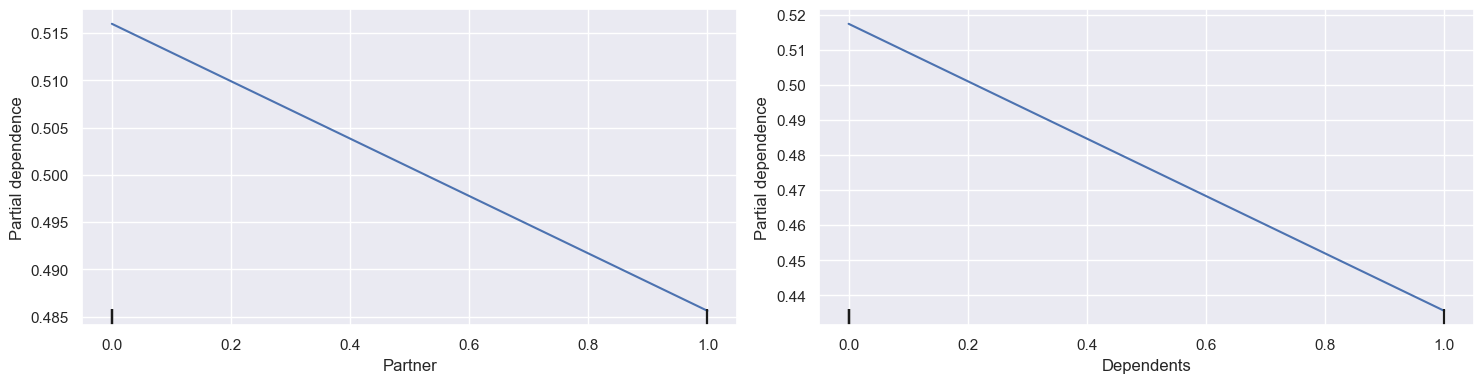

In [98]:
var_demo_ml = ['Partner', 'Dependents']
plot_pdp_1D(var_demo_ml, 1, 2, 4)

Observations:
- Both partner and depedents have impact on churn rate, but it's not big given the difference between the highest and lowest value in y-axis is small.

#### Subscribed services

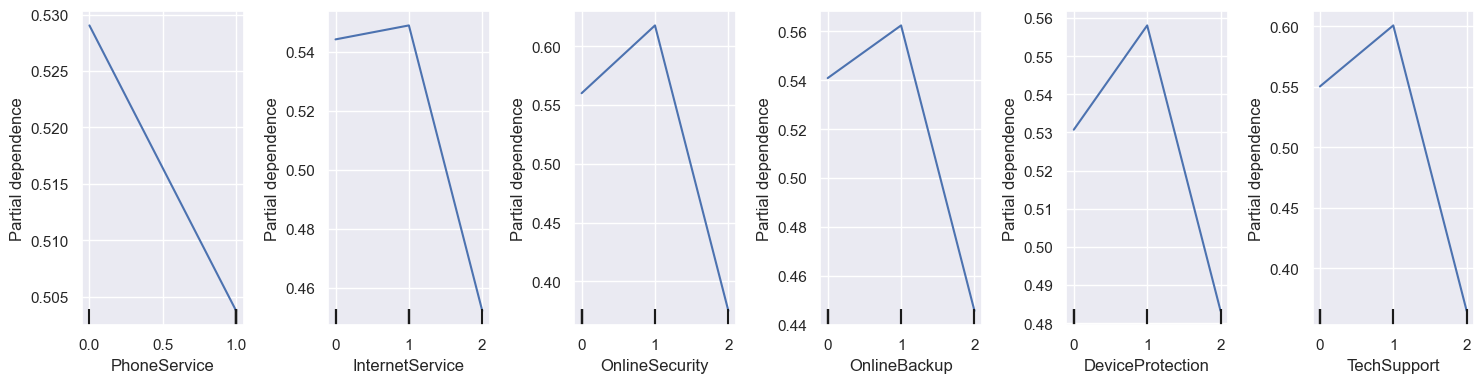

In [99]:
var_service_ml = [
    'PhoneService', 
    # 'MultipleLines', 
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    # 'StreamingTV', 
    # 'StreamingMovies'
    ]

plot_pdp_1D(var_service_ml, 1, 6, 4)

Observations:

- Customers are less likely to leave if they subscribe to online security and device protection, so we should promote these services to retain customers.
- Subscribing to online security reduces churn by about 18%, and tech support reduces it by around 19%, holding other factors constant. (On the plots, 0 = No to services, 2 = yes to services)

#### Account information

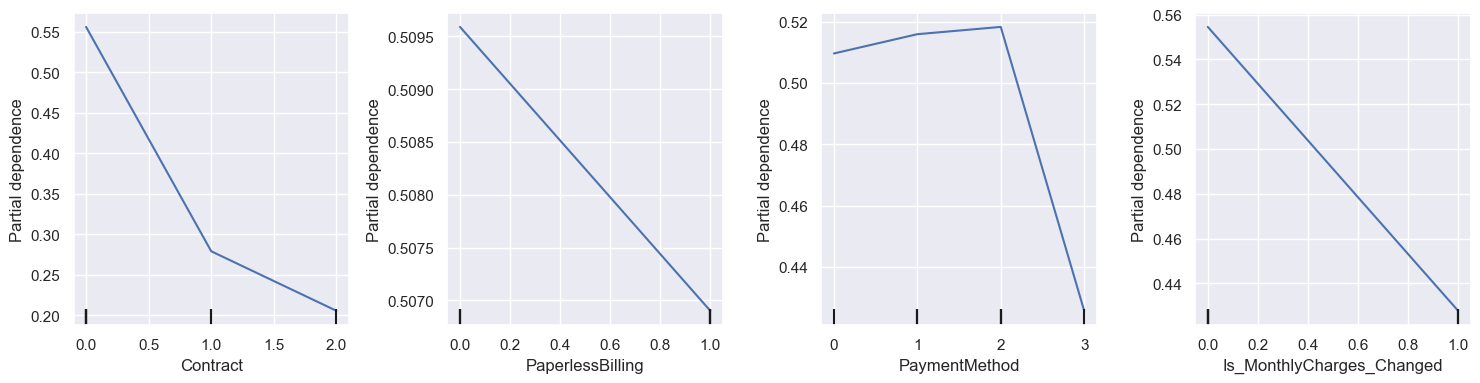

In [74]:
var_account_cat_ml = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Is_MonthlyCharges_Changed']
plot_pdp_1D(var_account_cat_ml, 1, 4, 4)

Observations:

- We can decrease churn rate by around 30% when customers are locked in 1 or 2 year contracts (1 = 1 year contract, 2 = 2 year contract, and 0 = month-to-month).
- From EDA, we know customers are more likely to leave when they pay with electronic check (label = 2), which aligns with the partial dependence plot. Surprisingly, customers are 10% less likely to churn when they pay with mail check (label = 3).
- Paperless billing has a minor impact on churn rate. 

### 2. Monthly charges vs other factors

Monthly charges significantly affect churn rate. We want to determine if customers are more willing to accept higher charges under specific circumstances so we can adapt our strategy accordingly.

We can make sure of 2D partial dependence plots, which shows predictions for any combination of 2 variables. 



**How to read the graphs?**
- X-axis: Monthly charges (scaled)
- Y-axis: The variable we want to see the correlation with monthly charges
- Contour: The churn probility (from 0 to 1) based on X and Y axis 

In [88]:
def plot_pdp_2D(variables, nrow, ncol, size):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i in range(len(variables)):         # Iterate over indices (because ax needs index too)
        PartialDependenceDisplay.from_estimator(rf_model, X_test_rf, [('MonthlyCharges_Scaled', variables[i])], ax=axes[i])

    plt.tight_layout()
    plt.show()

#### Family (Partner and dependents)

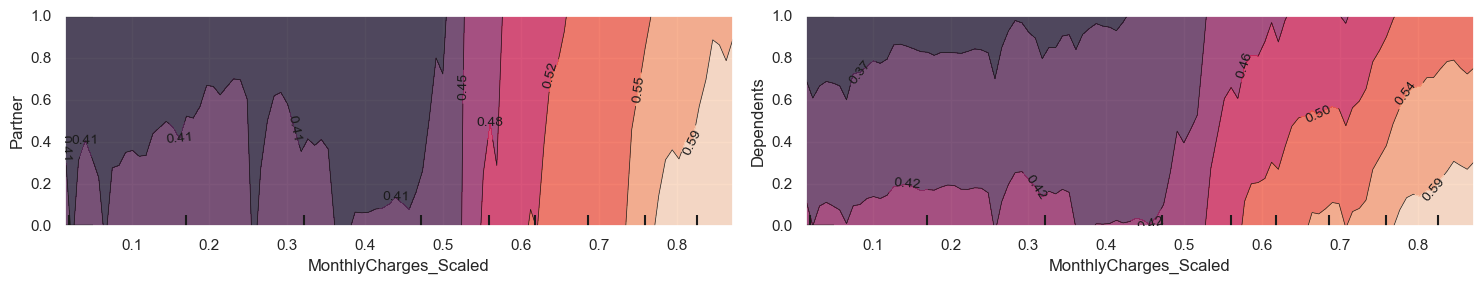

In [104]:
plot_pdp_2D(var_demo_ml, 1, 2, 3)

Observations:
- Customers with a partner tend to stay if monthly charges are below $68.5, but leave if charges go higher, with or without a partner.
- Customers with dependents are more accepting of higher charges. The chart shows a gradual decline in churn rates beyond the tipping point, unlike the sharp drop seen for those with a partner.

#### Subscribed services

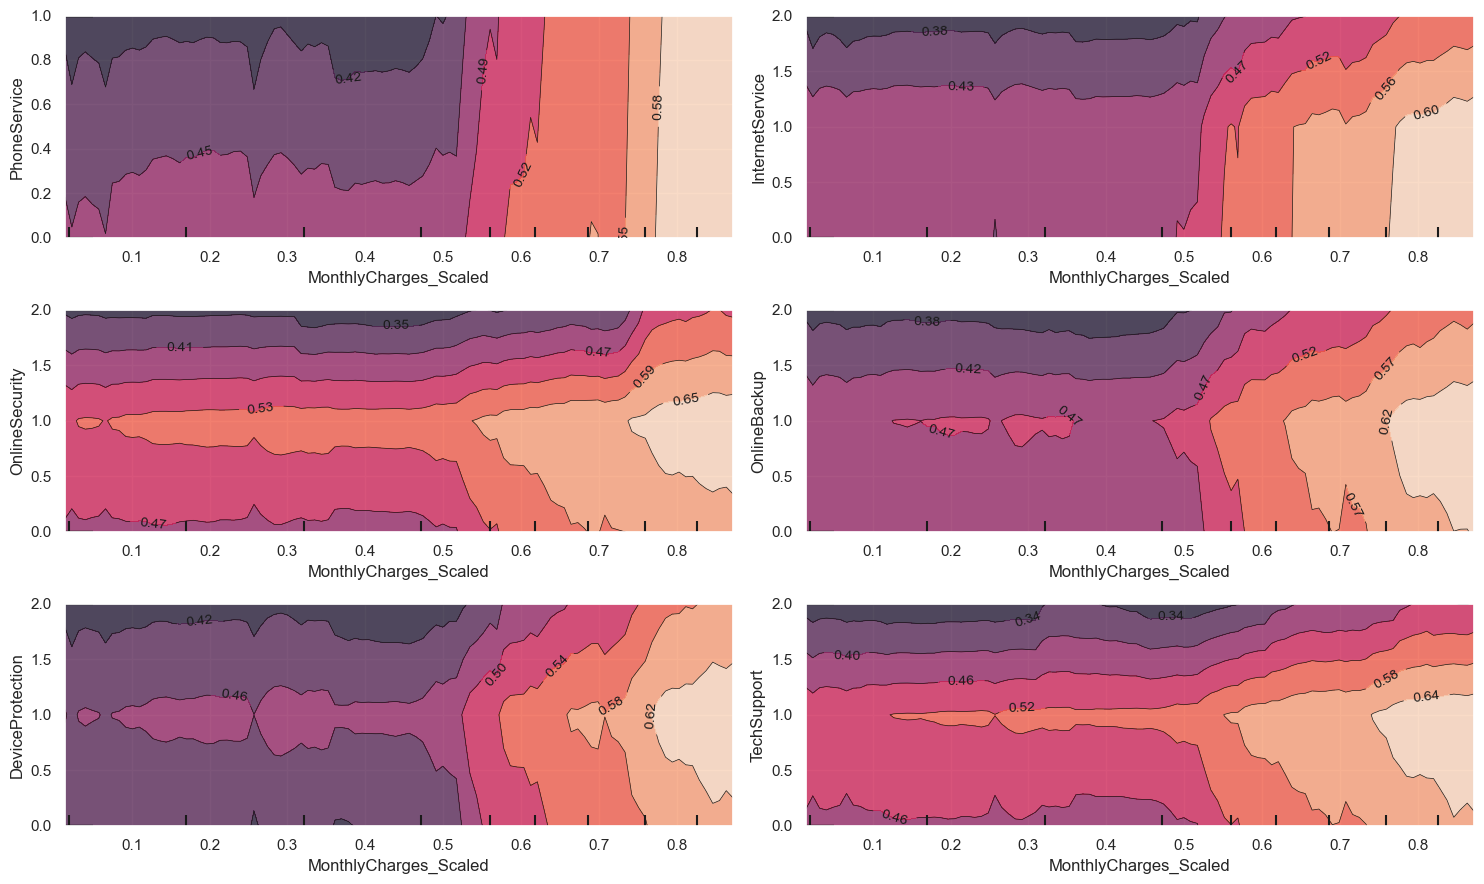

In [102]:
plot_pdp_2D(var_service_ml, 3, 2, 9)

In [130]:
tipping_point('MonthlyCharges', 0.7)
tipping_point('MonthlyCharges', 0.6)

Tipping point for MonthlyCharges: 88.6
Tipping point for MonthlyCharges: 78.55


Observations:
- Customers with phone service tend to stay if monthly charges are below $68.5, but leave if charges go higher.
- Fiber optic subscribers see a significant increase in churn if charged beyond the tipping point $68.5, possibly indicating issues with the service.
- Customers with online security leave when charges reach $88.6, $20 more than the baseline tipping point.
- Tech support users tolerate higher charges, only leaving when they approach $78.5.
- Online backup and device protection slightly increase price tolerance for customers, but not significantly.

#### Customer account information

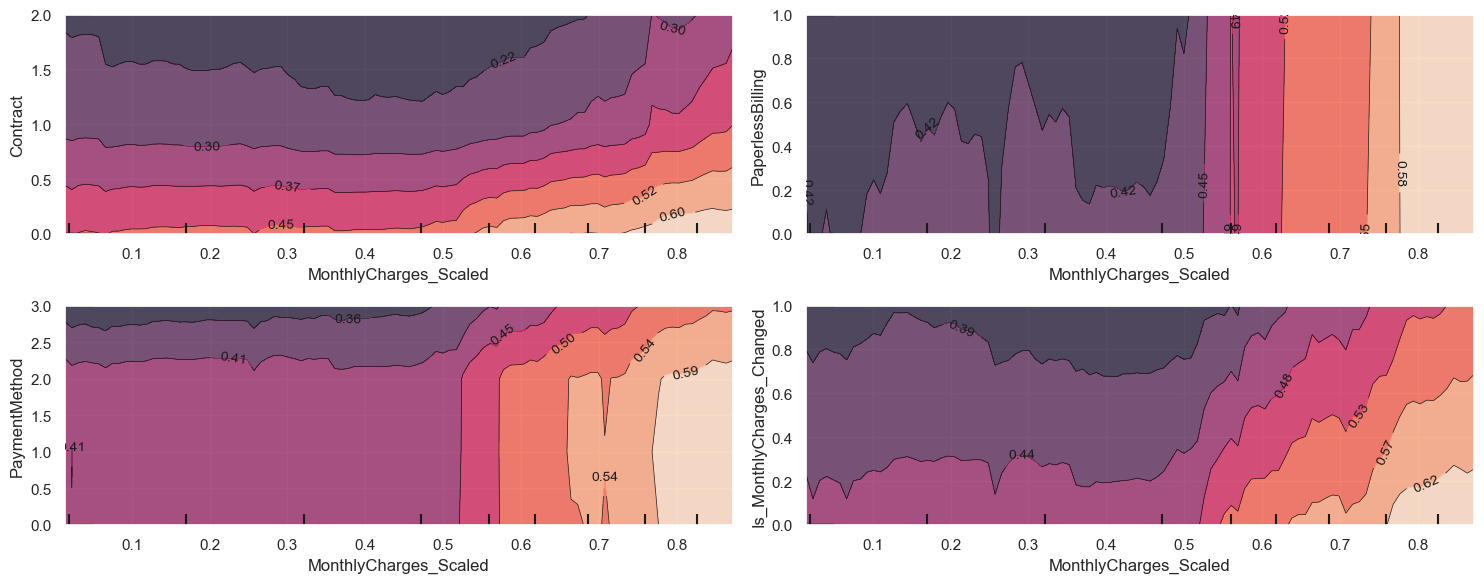

In [103]:
plot_pdp_2D(var_account_cat_ml, 2, 2, 6)

In [133]:
tipping_point('MonthlyCharges', 0.75)
tipping_point('MonthlyCharges', 0.5)
tipping_point('MonthlyCharges', 0.55)

Tipping point for MonthlyCharges: 93.625
Tipping point for MonthlyCharges: 68.5
Tipping point for MonthlyCharges: 73.525


Observations:

- Contracts greatly influence churn. Customers with 1 or 2-year contracts tolerate high prices, leaving only when charges reach $93, while month-to-month customers leave at $68.5.
- Customers using mail checks are more tolerant of prices. For other payment methods, they don't affect churn much for charges above $73.5.
- Paperless billing has no impact on churn when charges are above $73.5.
- Customers who have upgraded/downgraded their contract can handle higher prices.


### 3. Summary plot using SHAP
Permutation importance I used earlier is useful to compare which features mattered to a model, but it doesn't tell us how each feature matters. If a feature has medium permutation importance, it may mean it has a large effect for a few predictions but no effect overall, or a medium effect for all predctions. SHAP summary plot gives us a bird-eye view of feature importance and how each value is driving it. 

Per Kaggle, the SHAP summary plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


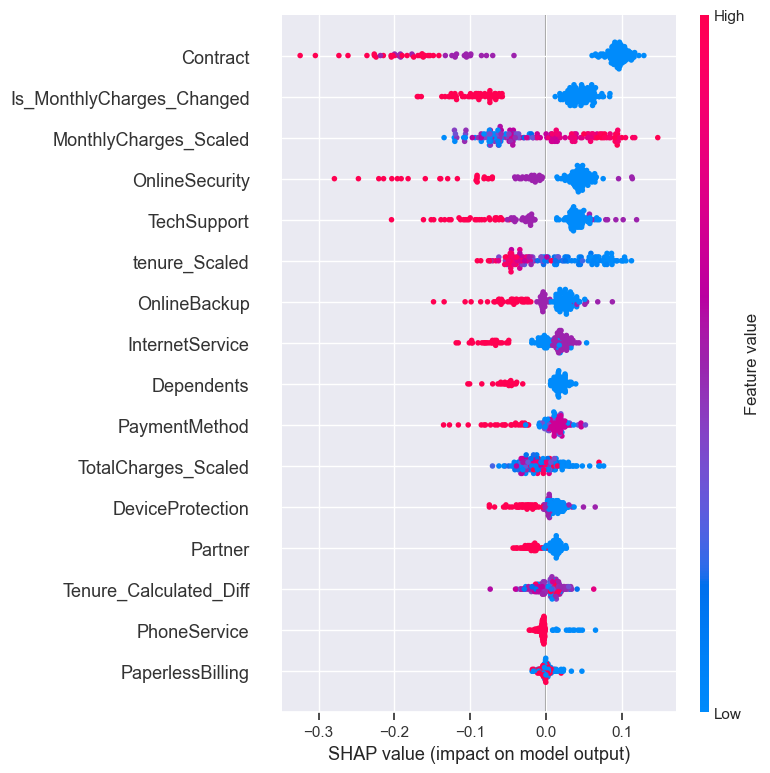

In [33]:
# For speed, we will calculate shap values on smaller subset of the validation data
# tips from kaggle learn
X_test_shap = X_test_rf[:150]

# shap explainer
# churn = 'yes' is labeled as 1, so it's shap_values[1]
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_shap)
shap.summary_plot(shap_values[1], X_test_shap)

Observations:
- At a glance, we notice certain variables (contract, monthly charges, online security, tech support) have a more significant impact on predictions These variables show a wider range between the most positive and negative effects.
- This analysis helps us verify if the machine learning model is working correctly. If the result is against our domain expertise, this may assist us in identifying and addressing any bugs in the model.

## L. Reference
- Mutual information: https://www.kaggle.com/code/ryanholbrook/mutual-information
- Random forest classification: https://www.datacamp.com/tutorial/random-forests-classifier-python
- XGBoost classifcation: https://www.kaggle.com/code/lucidlenn/data-analysis-and-classification-using-xgboost
- TensorFlow classification: https://www.youtube.com/watch?v=r3aZBohotF8
- Permutation importance (Kaggle Learn): https://www.kaggle.com/code/dansbecker/permutation-importance
- Confusion matrix in a reader-friendly presentation: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
- Advanced use of SHAP (Kaggle Learn): https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values
- Partial plots (Kaggle Learn): https://www.kaggle.com/code/dansbecker/partial-plots